#### Important Links (for attribute and database reference):

https://datasus.saude.gov.br/mortalidade-desde-1996-pela-cid-10

https://renastonline.ensp.fiocruz.br/sites/default/files/wiki/dicionario-sim.pdf

https://diaad.s3.sa-east-1.amazonaws.com/sim/Mortalidade_Geral+-+Estrutura.pdf

https://svs.aids.gov.br/download/Dicionario_de_Dados_SIM_tabela_DO.pdf

http://tabnet.datasus.gov.br/cgi/sim/Mortalidade_Geral_1996_2012.pdf

http://tabnet.datasus.gov.br/cgi/sim/Consolida_Sim_2011.pdf

ICD10 suicide codes used by DATASUS:

Códigos de suicídio usados pelo DATASUS do CID10:
http://www2.datasus.gov.br/cid10/V2008/WebHelp/v01_y98.htm#Cap20Nota01

#### DATASUS DATA:
```
ftp.datasus.gov.br
    /dissemin/publicos/SIM/CID10/DORES
    /dissemin/publicos/SIM/CID10/DOCS
```
Usual year update date:

![image.jpg](../utils/infos/attributes-desc/imgs/datasus_year_update_date.jpg)

In [33]:
# Importações
from IPython.display import display

import pandas as pd

import numpy as np
import datetime
import copy

import matplotlib.pyplot as plt

# if automatic converters are necessary
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Prevent infinite warnings
import warnings
warnings.filterwarnings('ignore')

In [34]:
# OS and File imports
import os
import sys

import importlib

from zipfile import ZipFile
from io import BytesIO

# List of directories to add to sys.path
directories_to_add = [
    os.path.abspath(os.path.join('..')),
    os.path.abspath(os.path.join('../utils')),
    os.path.abspath(os.path.join('../utils', 'functions')),
]

for directory in directories_to_add:
    if directory not in sys.path:
        sys.path.insert(0, directory)
print(sys.path)

['/home/user/coding_env/BrSuicides-dataset/utils/functions', '/home/user/coding_env/BrSuicides-dataset/utils', '/home/user/coding_env/BrSuicides-dataset', '/home/user/coding_env/BrSuicides-dataset/data_creation', '/mnt/d/.MESTRADO/.Orientacao/br-suicides-ts-analysis', '/mnt/d/.MESTRADO/.Orientacao/br-suicides-ts-analysis/data_analysis/utils', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/home/user/coding_env/venv311/lib/python3.11/site-packages']


In [35]:
# Making sure pycache is remade on kernel run since files are tiny
import color_palettes
importlib.reload(color_palettes)
import attributes_values_table_generator
importlib.reload(attributes_values_table_generator)
import preprocessing
importlib.reload(preprocessing)

from color_palettes import my_blue, my_orange
from attributes_values_table_generator import generate_attributes_values_table, get_values_table_columns, append_to_attributes_values_table, get_attributes_values_table
from preprocessing import initial_df_dtypes, initial_parse_dates, float_to_int, preprocess_date_column

In [36]:
root_dir = '..'

csv_dir = '/data_storage/'
csv_dir_dirty = csv_dir + '1_dirty/'
csv_dir_filtered = csv_dir + '2_filtered/'

csv_data_dir = os.path.dirname(root_dir + csv_dir) + '/'
print(csv_data_dir)

csv_data_dir_dirty = os.path.dirname(root_dir + csv_dir_dirty) + '/'
print(csv_data_dir_dirty)

csv_data_dir_filtered = os.path.dirname(root_dir + csv_dir_filtered) + '/'
print(csv_data_dir_filtered)

../data_storage/
../data_storage/1_dirty/
../data_storage/2_filtered/


In [37]:
# List all files in the csvs directory
all_files = os.listdir(csv_data_dir_dirty)

# Filter for files that end with .zip extension
csv_files = [file for file in all_files if file.endswith('.csv')]
print('CSVs: ', '\n', csv_files)

# Filter for files that end with .zip extension
csv_file_name = csv_files[0]
print('CSV file name: ', '\n', csv_file_name)

years_interval = csv_file_name.rsplit('-', 1)[1][0:-4].split('_')
print('Years interval: ', '\n' , years_interval)

# Years that will be downloaded, [1996,2023) interval
years = [x for x in range(int(years_interval[0]), (int(years_interval[-1]) + 1))]

print('Years:', '\n', years)

CSVs:  
 ['brazil-suicides-1996_2024.csv']
CSV file name:  
 brazil-suicides-1996_2024.csv
Years interval:  
 ['1996', '2024']
Years: 
 [1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


## Dataframe:

### Como os dados são coletados e sua granularidade:

As Secretarias de Saúde coletam as Declarações de Óbitos dos cartórios e entram, no SIM, as informações nelas contidas. Uma das informações primordiais é a causa básica de óbito, a qual é codificada a partir do declarado pelo médico atestante, segundo regras estabelecidas pela Organização Mundial de Saúde. A partir de 1996, as declarações de óbito passaram a ser codificadas utilizando-se a 10ª Revisão da Classificação Internacional de Doenças - CID-10. Até então, era utilizada a 9ª Revisão - CID-9. Devido às diferenças entre as revisões, não foi possível gerar uma lista que as compatibilizasse.

De uma maneira geral, as Secretarias Municipais e Estaduais de Saúde enviam periodicamente a sua Base de Dados para o Ministério da Saúde. Este só pode considerar a Base Nacional completa quando todas as UF enviaram seus dados. A partir daí, é feita a consolidação, inclusive com a redistribuição dos óbitos pelo local de residência, a qual é a forma tradicional de apresentar os dados de Mortalidade. Eventualmente, são feitas algumas correções nas informações, em conjunto com as Secretarias Municipais e Estaduais, principalmente quanto ao cruzamento de causa de óbito por sexo e idade.

### How the data is collected and their granularity:

The Health Departments collect Death Certificates from the registry offices and enter the information into the Mortality Information System (SIM). One of the primary pieces of information is the underlying cause of death, which is coded based on what the certifying physician declares, following rules established by the World Health Organization. Since 1996, death certificates have been coded using the 10th Revision of the International Classification of Diseases (ICD-10). Prior to that, the 9th Revision (ICD-9) was used. Due to differences between the revisions, it was not possible to generate a list that made them compatible.

Generally, Municipal and State Health Departments periodically send their databases to the Ministry of Health. The National Database can only be considered complete when all the states have submitted their data. From there, consolidation is done, including the redistribution of deaths by place of residence, which is the traditional way to present Mortality data. Occasionally, some corrections are made to the information, in conjunction with the Municipal and State Health Departments, especially concerning the cross-referencing of cause of death by sex and age.

Referência / Reference:
http://tabnet.datasus.gov.br/cgi/sim/Mortalidade_Geral_1996_2012.pdf


In [38]:
dataframe = pd.read_csv(csv_data_dir_dirty + csv_file_name, encoding='utf-8')
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301781 entries, 0 to 301780
Columns: 103 entries, ESTADO to ALTCAUSA
dtypes: float64(2), int64(6), object(95)
memory usage: 237.1+ MB


In [39]:
dataframe_columns = list(dataframe.columns)

print('Dataframe columns:\n', dataframe_columns)
print('\nNº of columns in dataframe: ', len(dataframe_columns))

Dataframe columns:
 ['ESTADO', 'ANO', 'level_2', 'contador', 'TIPOBITO', 'DTOBITO', 'NATURAL', 'DTNASC', 'IDADE', 'SEXO', 'RACACOR', 'ESTCIV', 'ESC', 'OCUP', 'CODBAIRES', 'CODMUNRES', 'LOCOCOR', 'CODMUNOCOR', 'IDADEMAE', 'ESCMAE', 'OCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GRAVIDEZ', 'GESTACAO', 'PARTO', 'OBITOPARTO', 'PESO', 'OBITOGRAV', 'OBITOPUERP', 'ASSISTMED', 'EXAME', 'CIRURGIA', 'NECROPSIA', 'CAUSABAS', 'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CIRCOBITO', 'ACIDTRAB', 'FONTE', 'CODESTAB', 'ATESTANTE', 'UFINFORM', 'CONTADOR', 'HORAOBITO', 'CODBAIOCOR', 'TPASSINA', 'DTATESTADO', 'TPPOS', 'DTINVESTIG', 'CAUSABAS_O', 'DTCADASTRO', 'FONTEINV', 'DTRECEBIM', 'CB_PRE', 'NUMERODN', 'ORIGEM', 'MORTEPARTO', 'DTCADINF', 'TPOBITOCOR', 'DTCADINV', 'COMUNSVOIM', 'DTRECORIG', 'DTRECORIGA', 'CAUSAMAT', 'ESC2010', 'ESCMAE2010', 'STDOEPIDEM', 'STDONOVA', 'SEMAGESTAC', 'TPMORTEOCO', 'DIFDATA', 'DTCONCASO', 'NUDIASOBIN', 'SERIESCFAL', 'SERIESCMAE', 'CODMUNCART', 'CODCART', 'NUMREGCART', 'DTRE

### Stripping leading and trailing whitespaces

In [40]:
# Removing leading and trailing whitespaces
def strip_strings_from_df(df):
    for col in df:
        if df[col].dtypes == object:
            if not pd.to_numeric(df[col], errors='coerce').isna().all() and col != "ESCFALAGR1":
                print(f'col: {col} is numeric')
                # Temporarily convert numbers to strings and strip whitespaces
                stripped = df[col].astype(str).str.strip()
                # Replace empty strings with np.nan to identify real empty values
                cleaned = stripped.replace('', np.nan)
                # Attempt to convert back to numeric where possible, keep as string if not
                df[col] = pd.to_numeric(cleaned, errors='coerce')
                df[col] = df[col].apply(float_to_int)
                
                # For entries that were just whitespace (now NaN), replace with empty strings
                df[col] = df[col].fillna('')
            else:
                print(f'col: {col} is not numeric')
                df[col] = df[col].str.strip()
    return df

In [41]:
dataframe_stripped = strip_strings_from_df(dataframe)

col: ESTADO is not numeric
col: NATURAL is numeric
col: DTNASC is numeric
col: IDADE is numeric
col: SEXO is numeric
col: RACACOR is numeric
col: ESTCIV is numeric
col: ESC is numeric
col: OCUP is numeric
col: CODBAIRES is numeric
col: LOCOCOR is numeric
col: IDADEMAE is numeric
col: ESCMAE is numeric
col: OCUPMAE is numeric
col: QTDFILVIVO is numeric
col: QTDFILMORT is numeric
col: GRAVIDEZ is numeric
col: GESTACAO is numeric
col: PARTO is numeric
col: OBITOPARTO is numeric
col: PESO is numeric
col: OBITOGRAV is numeric
col: OBITOPUERP is numeric
col: ASSISTMED is numeric
col: EXAME is numeric
col: CIRURGIA is numeric
col: NECROPSIA is numeric
col: CAUSABAS is not numeric
col: LINHAA is not numeric
col: LINHAB is not numeric
col: LINHAC is not numeric
col: LINHAD is not numeric
col: LINHAII is not numeric
col: CIRCOBITO is numeric
col: ACIDTRAB is numeric
col: FONTE is numeric
col: CODESTAB is numeric
col: ATESTANTE is numeric
col: UFINFORM is numeric
col: HORAOBITO is numeric
col: CO

## Filtragem dos atributos para disponibilizar a base de dados

Como o objetivo de disponibilizar essa base de dados se dá no contexto de casos de suicídio, inúmeros atributos foram filtrados, por serem administrativos, como VERSAOSIST, que define a versão do sistema usado para registro do caso de óbito, ou atributos que não são relacionados com suicídio, como "TPMORTEOCO", que define a situação gestacional ou pósgestacional em que ocorreu o óbito, configurando um óbito que não condiz com as condições de um suicídio. A seguir estão documentados os atributos removidos e o motivo pela sua remoção:

## Filtering Attributes to Provide the Database

Since the purpose of providing this database is within the context of suicide cases, numerous attributes were filtered out due to being administrative, such as VERSAOSIST, which defines the system version used for recording the death case, or attributes that are not related to suicide, such as "TPMORTEOCO", which defines the gestational or post-gestational situation in which the death occurred, representing a death that does not align with the conditions of a suicide. Below are the documented attributes removed and the reason for their removal:

In [42]:
df_attributes_info = pd.read_csv(root_dir + '/utils/infos/attributes-desc/datasus-attributes-info.csv')
print('Some info on the attributes from DATASUS:\n', df_attributes_info.head(4))
df_attributes_columns = list(df_attributes_info['name'])
print('\nColumns present in the pdfs:\n', df_attributes_columns)
print('\nNº of columns in dataframe: ', len(df_attributes_columns))

Some info on the attributes from DATASUS:
         name                                        description  year_added
0   ACIDTRAB  Indica se o evento que desencadeou o óbito est...        1979
1   ALTCAUSA  Indica se houve correção ou alteração da causa...        2014
2    AREARES                                                NaN        1979
3  ASSISTMED  Se refere ao atendimento médico continuado que...        1979

Columns present in the pdfs:
 ['ACIDTRAB', 'ALTCAUSA', 'AREARES', 'ASSISTMED', 'ATESTADO', 'ATESTANTE', 'BAIRES', 'CARTORIO', 'CAUSABAS', 'CAUSABAS_O', 'CAUSAMAT', 'CB_PRE', 'CIRCOBITO', 'CIRURGIA', 'CODBAIOCOR', 'CODBAIRES', 'CODCART', 'CODESTAB', 'CODIFICADO', 'CODIGO', 'CODMUNCART', 'CODMUNNATU', 'CODMUNOCOR', 'CODMUNRES', 'COMUNSVOIM', 'CONTADOR', 'CRITICA', 'CRM', 'CRSOCOR', 'CRSRES', 'DATANASC', 'DATAOBITO', 'DATAREG', 'DIFDATA', 'DTATESTADO', 'DTCADASTRO', 'DTCADINF', 'DTCADINV', 'DTCONCASO', 'DTCONINV', 'DTINVESTIG', 'DTNASC', 'DTOBITO', 'DTRECEBIM', 'DTRECORIG'

In [43]:
# Atributos relacionados a algum tipo de contador/indexação
ind_ats = ['level_2', 'contador', 'CONTADOR']
# Atributos relacionados a acidentes de trabalho
aci_ats = ['ACIDTRAB', 'LOCACID', 'TIPOACID']
# Atributos relacionados ao parto da vítima
# TPASSINA não tem informação, mas é parte de investigação materna
par_ats = ['MORTEPARTO', 'OBITOPARTO', 'TPASSINA', 'CAUSAMAT', 'OBITOGRAV', 
            'OBITOPUERP', 'SEMAGESTAC', 'SEMANGEST', 'TIPOBITO', 'TIPOPARTO',
            'TIPOGRAV', 'TPMORTEOCO', 'TPOBITOCOR', 'PARTO'
        ]
# Atributos relacionados ao registro da causa de óbito, administrativo
# Atributos relacionados a acontecimentos posteriores 
# à tentativa de cometimento de suicídio que intuitivamente
# não são relevantes para a análise de atributos que indiquem
# possível relações que levam ao suicídio.
reg_ats = ['ALTCAUSA', 'AREARES', 'ASSISTMED', 'ATESTANTE', 'CARTORIO', 
            'CIRURGIA', 'CB_PRE', 'CODCART', 'CODESTAB', 'CODIFICADO', 
            'CODIGO', 'COMUNSVOIM', 'CRITICA', 'CRM', 'DATAREG', 
            'DTATESTADO', 'DIFDATA', 'DTCADASTRO', 'DTCADINF', 'DTCADINV', 
            'DTCONCASO', 'DTCONINV', 'DTINVESTIG', 'DTRECEBIM', 'DTRECORIG', 
            'DTRECORIGA', 'DTREGCART', 'ESTABDESCR', 'EXAME', 'EXPDIFDATA', 
            'FONTE', 'FONTEINV', 'FONTES', 'FONTESINF', 'FONTINFO', 'LINHAA', 
            'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'NECROPSIA', 'NUDIASINF',
            'NUDIASOBCO', 'NUDIASOBIN', 'NUMERODN', 'NUMEROLOTE', 'NUMEXPORT', 
            'NUMREGCART', 'ORIGEM', 'REGISTRO', 'STCODIFICA', 'STDOEPIDEM', 
            'STDONOVA', 'TPNIVELINV', 'TPPOS', 'TPRESGINFO', 'VERSAOSCB', 
            'VERSAOSIST',
        ]
# Atributos relacionados ao target, "CAUSABAS", que foi escolhido devido
# à maior confiança percebida para definição de um óbito como suicídio.
cau_ats = ['ATESTADO', 'CAUSABAS_O', 'CIRCOBITO', 'TIPOVIOL']
# Outros atributos que são inúteis devido a outros atributos
use_ats = ['SERIESCFAL', 'SERIESCMAE']
# Atributos que podem ser usados
# Atributos relacionados à ocorrência
oco_ats = ['CODBAIOCOR', 'CODMUNCART', 'CODMUNOCOR', 'CRSOCOR', 'LOCOCOR', 
            'MUNIOCOR', 'UFINFORM']
# Atributos relacionados à residência
res_ats = ['BAIRES', 'CODBAIRES', 'CODMUNNATU', 'CODMUNRES', 'CRSRES', 'MUNIRES']
# Atributos de data
date_ats = ['DATAOBITO', 'DTOBITO', 'DTNASC', 'DATANASC']
# Atributos não filtrados
notf_ats = ['CAUSABAS',  
            'ESC', 'ESC2010', 'ESCFALAGR1', 'ESTCIV', 'ESTCIVIL', 
            'ETNIA', 'OCUP', 'OCUPACAO', 'RACACOR', 'SEXO', 
            'HORAOBITO', 'IDADE']
# Interesting? attributes
int_ats = ['ESCMAE', 'ESCMAE2010', 'ESCMAEAGR1', 'FILHMORT', 'FILHVIVOS', 
            'IDADEMAE', 'INSTRMAE', 'INSTRPAI', 'INSTRUCAO', 'OBITOFE1', 
            'OBITOFE2', 'OCUPMAE', 'OCUPPAI', 'GESTACAO', 'GRAVIDEZ', 'LOCACID',
            'NATURAL', 'PESO', 'PESONASC', 'QTDFILMORT', 'QTDFILVIVO']

cre_ats = ['ESTADO', 'ANO', 'MES']

print('Nº of administrative attributes: ', len(reg_ats))
attributes_to_remove = ind_ats + aci_ats + par_ats + cau_ats + use_ats
print('Nº of the rest of the attributes: ', len(attributes_to_remove))
attributes_to_remove += reg_ats
print('Nº of all attributes to remove: ', len(attributes_to_remove))

ats_to_keep = oco_ats + res_ats + date_ats + notf_ats + int_ats + cre_ats
print('Nº of attributes to keep: ', len(ats_to_keep))

Nº of administrative attributes:  58
Nº of the rest of the attributes:  26
Nº of all attributes to remove:  84
Nº of attributes to keep:  54


In [44]:
print('All dataframe columns:\n', dataframe_columns)
print(len(dataframe_columns))
print('\nAttributes to remove:\n', attributes_to_remove)
print(len(attributes_to_remove))

existing_attributes_to_remove = [col for col in attributes_to_remove if col in dataframe_columns]

print('\nAttributes to remove that exist:\n', existing_attributes_to_remove)
print(len(existing_attributes_to_remove))

All dataframe columns:
 ['ESTADO', 'ANO', 'level_2', 'contador', 'TIPOBITO', 'DTOBITO', 'NATURAL', 'DTNASC', 'IDADE', 'SEXO', 'RACACOR', 'ESTCIV', 'ESC', 'OCUP', 'CODBAIRES', 'CODMUNRES', 'LOCOCOR', 'CODMUNOCOR', 'IDADEMAE', 'ESCMAE', 'OCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GRAVIDEZ', 'GESTACAO', 'PARTO', 'OBITOPARTO', 'PESO', 'OBITOGRAV', 'OBITOPUERP', 'ASSISTMED', 'EXAME', 'CIRURGIA', 'NECROPSIA', 'CAUSABAS', 'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CIRCOBITO', 'ACIDTRAB', 'FONTE', 'CODESTAB', 'ATESTANTE', 'UFINFORM', 'CONTADOR', 'HORAOBITO', 'CODBAIOCOR', 'TPASSINA', 'DTATESTADO', 'TPPOS', 'DTINVESTIG', 'CAUSABAS_O', 'DTCADASTRO', 'FONTEINV', 'DTRECEBIM', 'CB_PRE', 'NUMERODN', 'ORIGEM', 'MORTEPARTO', 'DTCADINF', 'TPOBITOCOR', 'DTCADINV', 'COMUNSVOIM', 'DTRECORIG', 'DTRECORIGA', 'CAUSAMAT', 'ESC2010', 'ESCMAE2010', 'STDOEPIDEM', 'STDONOVA', 'SEMAGESTAC', 'TPMORTEOCO', 'DIFDATA', 'DTCONCASO', 'NUDIASOBIN', 'SERIESCFAL', 'SERIESCMAE', 'CODMUNCART', 'CODCART', 'NUMREGCART', '

In [45]:
# filtered_df_1: dataframe with stripped spaces and 
# irrelevant attributes removed
filtered_df_1 = dataframe_stripped.drop(columns=existing_attributes_to_remove)
filtered_df_1_columns = list(filtered_df_1.columns)

print('filtered_df_1 columns:\n', sorted(filtered_df_1_columns))
print('\nNº of columns in filtered_df_1: ', len(filtered_df_1_columns))

filtered_df_1 columns:
 ['ANO', 'CAUSABAS', 'CODBAIOCOR', 'CODBAIRES', 'CODMUNCART', 'CODMUNNATU', 'CODMUNOCOR', 'CODMUNRES', 'DTNASC', 'DTOBITO', 'ESC', 'ESC2010', 'ESCFALAGR1', 'ESCMAE', 'ESCMAE2010', 'ESCMAEAGR1', 'ESTADO', 'ESTCIV', 'GESTACAO', 'GRAVIDEZ', 'HORAOBITO', 'IDADE', 'IDADEMAE', 'LOCOCOR', 'NATURAL', 'OCUP', 'OCUPMAE', 'PESO', 'QTDFILMORT', 'QTDFILVIVO', 'RACACOR', 'SEXO', 'UFINFORM']

Nº of columns in filtered_df_1:  33


## Generating attributes values info dataframe:

In [46]:
dir_to_attributes_info_tables = '../brsuicides_info_tables'

attributes_values_table_path = generate_attributes_values_table(dir_to_attributes_info_tables)
print(pd.read_csv(attributes_values_table_path))

values_table_columns = get_values_table_columns('BR')

Empty DataFrame
Columns: [Atributo, Faltantes/Nulos, Inválidos, Válidos, Tratados, Removidos]
Index: []


#### Handling DTOBITO first to use it to calculate percentages of missing values

In [47]:
# filtered_df_2: dataframe with DTOBITO preprocessed
filtered_df_2, DTOBITO_values_info = preprocess_date_column(filtered_df_1, 'DTOBITO', remove_invalid=True)

Column: DTOBITO
Unstandardized date example:
0    24101996
1     4021996
Name: DTOBITO, dtype: int64

Standardized date example:
0   1996-10-24
1   1996-02-04
Name: DTOBITO, dtype: datetime64[ns]

Nº of removed DTOBITO invalid rows: 52

Example of removed DTOBITO invalid rows:
197    NaT
1249   NaT
1287   NaT
2002   NaT
2449   NaT
Name: DTOBITO, dtype: datetime64[ns]



In [48]:
# Invalid date rows
display(dataframe['DTOBITO'][197:198])
display(dataframe['DTOBITO'][1129:1130])

197    31996
Name: DTOBITO, dtype: int64

1129    6071996
Name: DTOBITO, dtype: int64

### Appending 'DTOBITO', 'ESTADO' and 'ANO' to the attributes values info table

In [49]:
append_to_attributes_values_table(dir_to_attributes_info_tables, DTOBITO_values_info)

# No change in 'ESTADO'
ESTADO_values_info = ['ESTADO', 0, 0, len(filtered_df_2), 0, 0]
append_to_attributes_values_table(dir_to_attributes_info_tables, ESTADO_values_info)

# No change in 'ANO'
YEAR_values_info = ['ANO', 0, 0, len(filtered_df_2), 0, 0]
append_to_attributes_values_table(dir_to_attributes_info_tables, YEAR_values_info)

# No change in 'CAUSABAS'
CAUSABAS_values_info = ['CAUSABAS', 0, 0, len(filtered_df_2), 0, 0]
append_to_attributes_values_table(dir_to_attributes_info_tables, CAUSABAS_values_info)

## Calculating and showing missing values

In [50]:
# Calculates missing percentages for each attribute
def calculate_attr_missing_percentages(df, df_attrs_info):
    df_columns = list(df.columns)
    missing_dict = {
        'attr': [],
        'missing_pct_at': [],
        'missing_pct_sa': [],
        'year_added': []
    }
    
    for col in df_columns:
        if col in df_attrs_info['name'].values:
            year_added = df_attrs_info.loc[df_attrs_info['name'] == col, 'year_added'].values[0]
            missing_dict['attr'].append(col)
            missing_dict['year_added'].append(year_added)
            
            # Calculate the percentage of missing for all time
            missing_pct_at = (df[col].isna() | (df[col] == '')).mean() * 100
            missing_dict['missing_pct_at'].append(missing_pct_at)
            
            # Filter rows where 'DTOBITO' is after 'year_added'
            relevant_rows = df[df['DTOBITO'].dt.year >= year_added]
            missing_pct_sa = (relevant_rows[col].isna() | (relevant_rows[col] == '')).mean() * 100 if not relevant_rows.empty else None
            missing_dict['missing_pct_sa'].append(missing_pct_sa)
    
    missing_df = pd.DataFrame(missing_dict)
    return missing_df

In [51]:
def plot_missing_pct_histograms(df_to_check):
    # Calcular a soma dos percentuais nulos
    df_to_check['total_missing_pct'] = df_to_check['missing_pct_at'] + df_to_check['missing_pct_sa']
    # Ordenar o DataFrame com base na soma dos percentuais nulos
    df_to_check = df_to_check.sort_values(by='total_missing_pct', ascending=False).reset_index(drop=True)
    
    num_attrs = len(df_to_check)
    num_cols = 3
    num_rows = (num_attrs + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    axes = axes.flatten()

    for idx, row in df_to_check.iterrows():
        attr = row['attr']
        year_added = row['year_added']
        missing_pct_at = row['missing_pct_at']
        missing_pct_sa = row['missing_pct_sa']

        percentages = [missing_pct_at, missing_pct_sa]
        labels = ['All time', 'Since added']

        ax = axes[idx]
        ax.bar(labels, percentages, color=[my_blue, my_orange])
        ax.set_ylim(0, 100)
        ax.set_yticks(range(0, 101, 10))
        ax.set_title(f'{attr}: {year_added}', fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Hide any empty subplots
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.suptitle("Attributes missing percentages", fontsize=16)
    plt.tight_layout(rect=[0, 0.1, 1, 0.9825])
    plt.show()

In [52]:
# Calculate the missing percentages and create the summary dataframe
attributes_missing_pct_df_2 = calculate_attr_missing_percentages(filtered_df_2, df_attributes_info)
attributes_missing_pct_df_2

,attr,missing_pct_at,missing_pct_sa,year_added
0,DTOBITO,0.000000,0.000000,1996
1,NATURAL,15.263697,15.263697,1979
2,DTNASC,0.672789,0.672789,1996
3,IDADE,0.052696,0.052696,1979
4,SEXO,0.001326,0.001326,1979
5,RACACOR,7.229666,7.229666,1995
6,ESTCIV,3.016283,3.016283,1996
7,ESC,14.076870,14.076870,1996
8,OCUP,18.401281,18.401281,1996
9,CODBAIRES,86.024545,86.024545,1996


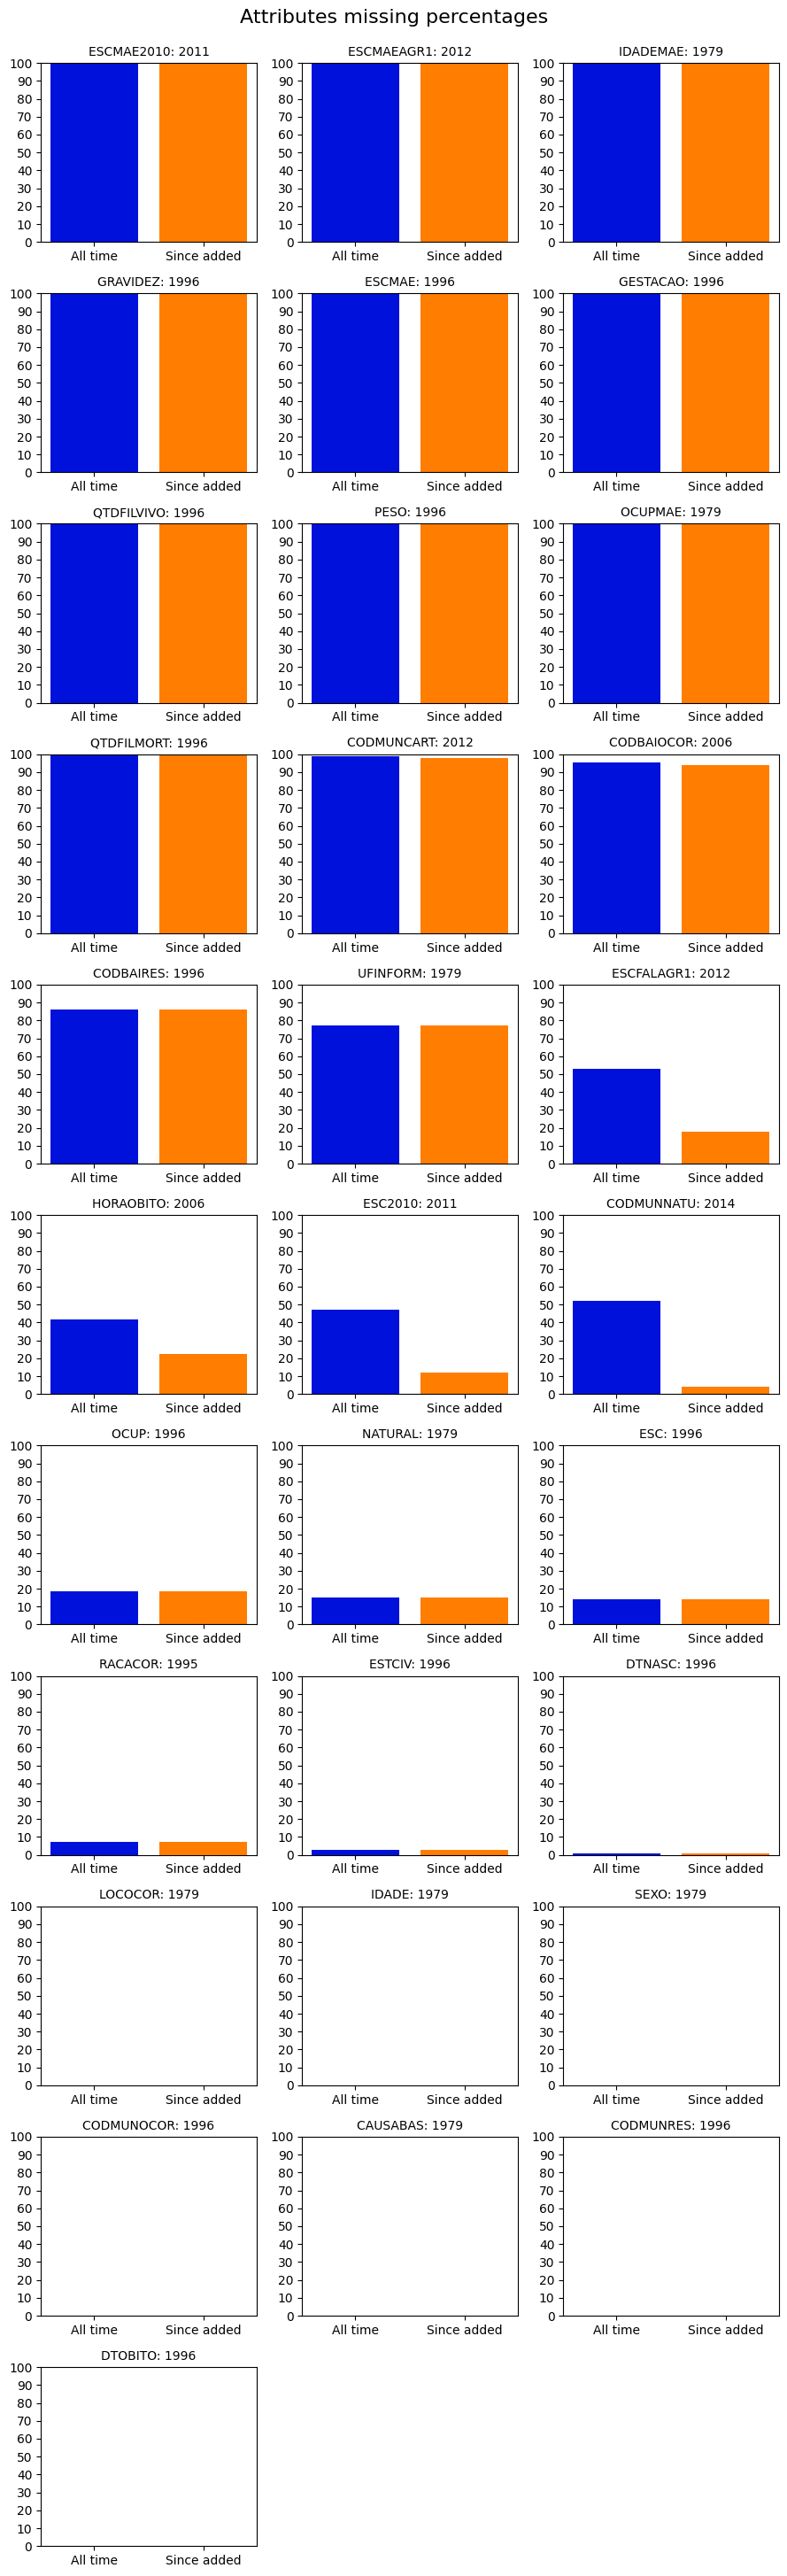

In [53]:
plot_missing_pct_histograms(attributes_missing_pct_df_2)

In [54]:
# Sampling some data from columns with more than missing_pct_threshold missing
# based on "since added" column, meaning that even data that should exist don't.
missing_pct_threshold = 50
missing_pct_threshold_columns = attributes_missing_pct_df_2[attributes_missing_pct_df_2['missing_pct_sa'] >= missing_pct_threshold]['attr']
for col in missing_pct_threshold_columns:
    print(f"\nSample data from column '{col}':")
    print(filtered_df_2[col].sample(2, random_state=1469))


Sample data from column 'CODBAIRES':
10208     
186535    
Name: CODBAIRES, dtype: object

Sample data from column 'IDADEMAE':
10208     
186535    
Name: IDADEMAE, dtype: object

Sample data from column 'ESCMAE':
10208     
186535    
Name: ESCMAE, dtype: object

Sample data from column 'OCUPMAE':
10208     
186535    
Name: OCUPMAE, dtype: object

Sample data from column 'QTDFILVIVO':
10208     
186535    
Name: QTDFILVIVO, dtype: object

Sample data from column 'QTDFILMORT':
10208     
186535    
Name: QTDFILMORT, dtype: object

Sample data from column 'GRAVIDEZ':
10208     
186535    
Name: GRAVIDEZ, dtype: object

Sample data from column 'GESTACAO':
10208     
186535    
Name: GESTACAO, dtype: object

Sample data from column 'PESO':
10208     
186535    
Name: PESO, dtype: object

Sample data from column 'UFINFORM':
10208     
186535    
Name: UFINFORM, dtype: object

Sample data from column 'CODBAIOCOR':
10208     
186535    
Name: CODBAIOCOR, dtype: object

Sample data from col

In [55]:
missing_pct_99_columns = list(attributes_missing_pct_df_2[attributes_missing_pct_df_2['missing_pct_sa'] >= 99]['attr'])
print(f'All columns that have more than 99% missing data: {len(missing_pct_99_columns)}')
for col in missing_pct_99_columns:
    print(f"{col}")

print()
missing_pct_threshold_columns = list(attributes_missing_pct_df_2[(missing_pct_threshold <= attributes_missing_pct_df_2['missing_pct_sa'])
                                               & (attributes_missing_pct_df_2['missing_pct_sa'] < 99)]['attr'])
print(f'All columns that fail the threshold of {missing_pct_threshold}%: {len(missing_pct_threshold_columns)}')
for col in missing_pct_threshold_columns:
    print(f"{col}")

# Joins both lists
missing_pct_threshold_columns += missing_pct_99_columns

All columns that have more than 99% missing data: 10
IDADEMAE
ESCMAE
OCUPMAE
QTDFILVIVO
QTDFILMORT
GRAVIDEZ
GESTACAO
PESO
ESCMAE2010
ESCMAEAGR1

All columns that fail the threshold of 50%: 4
CODBAIRES
UFINFORM
CODBAIOCOR
CODMUNCART


### Filtering too many missing based on year of addition

There are many columns that have more than the threshold of missing in the database, even on data that should exist based on the date the attribute started being used, so they are being removed. The threshold is arbitrary, but 'missing_pct_threshold' is too much.

In [56]:
print('Nº of columns before filtering the missing:', len(filtered_df_2.columns))

filtered_df_3 = filtered_df_2.drop(columns=list(missing_pct_threshold_columns))
print('Nº of columns after filtering the missing:', len(filtered_df_3.columns))

filtered_df_3_columns = list(filtered_df_3.columns)
# Filter df_attributes_info to only include columns that are in filtered_df_3
filtered_df_3_attributes_info = df_attributes_info[df_attributes_info['name'].isin(filtered_df_3_columns)]

Nº of columns before filtering the missing: 33
Nº of columns after filtering the missing: 19


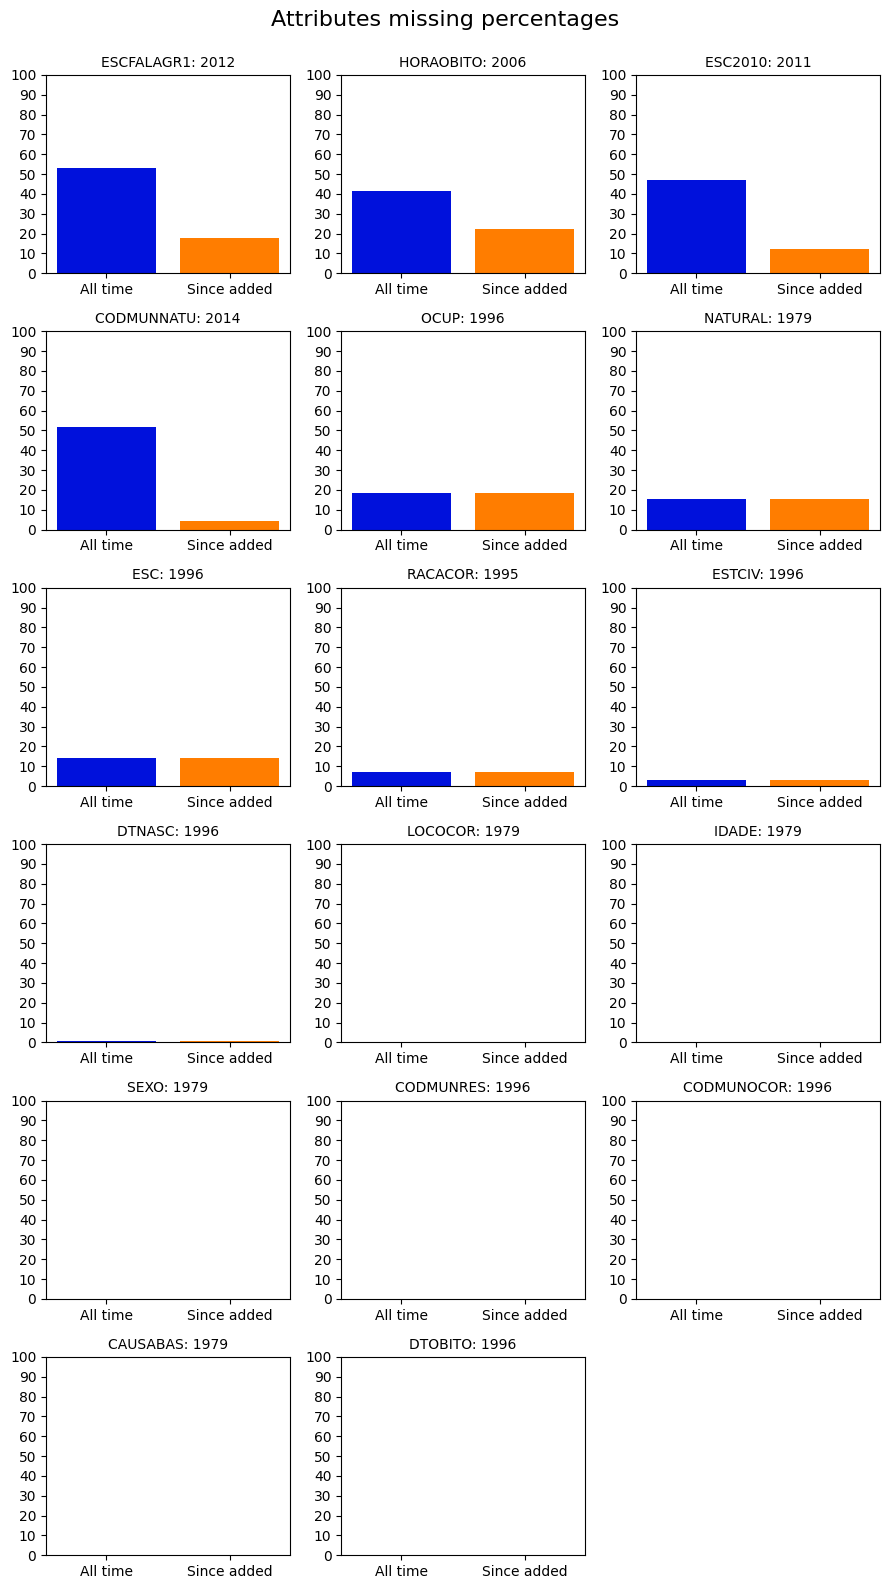

In [57]:
# Calculate the missing percentages and create the summary dataframe
attributes_missing_pct_df_3 = calculate_attr_missing_percentages(filtered_df_3, filtered_df_3_attributes_info)

plot_missing_pct_histograms(attributes_missing_pct_df_3)

### Filtering too many missing based on the year of data collection

CODMUNNATU and HORAOBITO
have too many missing for all time , since they were added in 2014 and 2006, respectively:

In [58]:
print('Nº of missing for CODMUNNATU:', attributes_missing_pct_df_3['missing_pct_at'][attributes_missing_pct_df_3['attr'] == 'CODMUNNATU'].values[0])
print('Nº of missing for HORAOBITO:', attributes_missing_pct_df_3['missing_pct_at'][attributes_missing_pct_df_3['attr'] == 'HORAOBITO'].values[0])

Nº of missing for CODMUNNATU: 51.9147977158311
Nº of missing for HORAOBITO: 41.443480739338945


In [59]:
if 'CODMUNNATU' and 'HORAOBITO' in filtered_df_3.columns:
    filtered_df_3 = filtered_df_3.drop(columns=['CODMUNNATU', 'HORAOBITO'], inplace=False)
filtered_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301729 entries, 0 to 301780
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ESTADO      301729 non-null  object        
 1   ANO         301729 non-null  int64         
 2   DTOBITO     301729 non-null  datetime64[ns]
 3   NATURAL     301729 non-null  object        
 4   DTNASC      301729 non-null  object        
 5   IDADE       301729 non-null  object        
 6   SEXO        301729 non-null  object        
 7   RACACOR     301729 non-null  object        
 8   ESTCIV      301729 non-null  object        
 9   ESC         301729 non-null  object        
 10  OCUP        301729 non-null  object        
 11  CODMUNRES   301729 non-null  int64         
 12  LOCOCOR     301729 non-null  object        
 13  CODMUNOCOR  301729 non-null  int64         
 14  CAUSABAS    301729 non-null  object        
 15  ESC2010     301729 non-null  object        
 16  ESCFALA

## Creating the csv for the next preprocessing step

In [60]:
filtered_df_3.to_csv(csv_data_dir_filtered + csv_file_name, index=False)

In [61]:
dataframe_filtered = pd.read_csv(csv_data_dir_filtered + csv_file_name, dtype=initial_df_dtypes, parse_dates=initial_parse_dates)
dataframe_filtered

,ESTADO,ANO,DTOBITO,NATURAL,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC,OCUP,CODMUNRES,LOCOCOR,CODMUNOCOR,CAUSABAS,ESC2010,ESCFALAGR1
0,PR,1996,1996-10-24,841,5081963,433,1,NaN,1,1,61200,4119251,5,4119251,X709,NaN,NaN
1,PR,1996,1996-02-04,152,21091920,475,1,NaN,2,1,62100,4101903,3,4101903,X680,NaN,NaN
2,PR,1996,1996-01-17,841,28081961,434,1,NaN,1,NaN,62100,4100103,1,4100103,X680,NaN,NaN
3,PR,1996,1996-02-07,841,24091977,418,1,NaN,1,1,62100,4123204,1,4126009,X680,NaN,NaN
4,PR,1996,1996-02-09,841,30081956,439,1,NaN,5,NaN,62100,4123907,3,4123907,X700,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301724,MT,2024,2024-12-30,851,6011984,440,1,1,2,4,21205,510795,3,510795,X740,3,06
301725,MT,2024,2024-12-30,821,31072002,422,1,4,5,3,NaN,510788,3,510020,X700,2,11
301726,MT,2024,2024-12-31,850,8101969,455,1,4,5,3,782510,510030,1,510760,X690,1,02
301727,MT,2024,2024-12-31,851,5111994,430,1,4,1,9,991405,510125,3,510125,X700,9,09


In [62]:
dataframe_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301729 entries, 0 to 301728
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ESTADO      301729 non-null  object        
 1   ANO         301729 non-null  int64         
 2   DTOBITO     301729 non-null  datetime64[ns]
 3   NATURAL     255674 non-null  object        
 4   DTNASC      299699 non-null  object        
 5   IDADE       301570 non-null  object        
 6   SEXO        301725 non-null  object        
 7   RACACOR     279915 non-null  object        
 8   ESTCIV      292628 non-null  object        
 9   ESC         259255 non-null  object        
 10  OCUP        246207 non-null  object        
 11  CODMUNRES   301729 non-null  int64         
 12  LOCOCOR     301325 non-null  object        
 13  CODMUNOCOR  301729 non-null  int64         
 14  CAUSABAS    301729 non-null  object        
 15  ESC2010     160230 non-null  object        
 16  ES

### Generating the attributes description csv:

In [63]:
file_attributes_description = pd.DataFrame({
    'name':['ESTADO', 'ANO'], 
    'description':[
        'Estado presente no nome do arquivo .DBF do qual os dados são obtidos.',
        'Ano presente no nome do arquivo .DBF do qual os dados são obtidos.'
    ], 
    'year_added':['', '']})

df_filtered_columns = list(dataframe_filtered.columns)
print(df_filtered_columns)
df_attributes_description_filtered = df_attributes_info[df_attributes_info['name'].isin(df_filtered_columns)]
df_attributes_description_filtered = pd.concat([file_attributes_description, df_attributes_description_filtered]).reset_index(drop=True)
display(df_attributes_description_filtered)

df_attributes_description_filtered.to_csv(dir_to_attributes_info_tables + '/attributes_description.csv', index=False)

['ESTADO', 'ANO', 'DTOBITO', 'NATURAL', 'DTNASC', 'IDADE', 'SEXO', 'RACACOR', 'ESTCIV', 'ESC', 'OCUP', 'CODMUNRES', 'LOCOCOR', 'CODMUNOCOR', 'CAUSABAS', 'ESC2010', 'ESCFALAGR1']


,name,description,year_added
0,ESTADO,Estado presente no nome do arquivo .DBF do qua...,
1,ANO,Ano presente no nome do arquivo .DBF do qual o...,
2,CAUSABAS,Causa básica da DO. (Códigos CID 10),1979
3,CODMUNOCOR,Código relativo ao município onde ocorreu o ób...,1996
4,CODMUNRES,Código do município de residência. Em caso de ...,1996
5,DTNASC,Data do nascimento do falec ido. Em caso de ób...,1996
6,DTOBITO,Data em que occoreu o óbito.(Data no padrão dd...,1996
7,ESC,Escolaridade em anos. (1 – Nenhuma; 2 – de 1 a...,1996
8,ESC2010,Escolaridade 2010. Nível da última série concl...,2011
9,ESCFALAGR1,Escolaridade do falecido agregada (formulário ...,2012
